# K-Nearest Neighbours

In [12]:
import time
from typing import Any

import numpy as np
import pandas as pd
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, precision_score, \
    recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [13]:
# Exclusion list and column definitions
exclusion_list = ['num_outbound_cmds', 'attack_category', 'success_pred', 'attack_type']
nominal = ['protocol_type', 'service', 'flag']
binary = ['land', 'logged_in', 'root_shell', 'su_attempted', 'is_host_login', 'is_guest_login']

In [14]:
#### Helper Functions
def define_numeric_column(data: pd.DataFrame) -> list[Any]:
    return [col for col in data.columns if col not in nominal + binary + exclusion_list]

def print_score(y_test, y_test_pred, training_time, train_accuracy, test_accuracy):
    precision = precision_score(y_test, y_test_pred, average='weighted')
    recall = recall_score(y_test, y_test_pred, average='weighted')
    f1 = f1_score(y_test, y_test_pred, average='weighted')
    print(f"KNN WITH PIPELINE (PCA + ADASYN + ENN)")
    print("===========================================================================")
    print("\nClassification Report:\n", classification_report(y_test, y_test_pred))
    print("Model Evaluation:")
    print(f"Training Time: {training_time:.4f} seconds")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Testing Accuracy: {test_accuracy:.4f}")
    print(f"Precision (Weighted): {precision:.4f}")
    print(f"Recall (Weighted): {recall:.4f}")
    print(f"F1-Score (Weighted): {f1:.4f}")

    conf_matrix = confusion_matrix(y_test, y_test_pred)
    class_names = np.unique(y_test)  # Use y_test to ensure test set classes
    print("\nConfusion Matrix with Class Labels:")
    print(pd.DataFrame(conf_matrix, index=class_names, columns=class_names))

def check_fitting(train_accuracy, test_accuracy):
    print("\nOverfitting/Underfitting Diagnosis:")
    if train_accuracy > test_accuracy + 0.05:
        print("Possible Overfitting: Training accuracy is significantly higher than testing accuracy.")
    elif train_accuracy < 0.7 and test_accuracy < 0.7:
        print("Possible Underfitting: Both training and testing accuracies are low.")
    else:
        print("Good Fit: Training and testing accuracies are reasonably close.")

def preprocess_data(data: pd.DataFrame) -> tuple:
    try:
        data = data.copy()
        data['su_attempted'] = data['su_attempted'].replace({2: 0}, inplace=False)
        numeric = define_numeric_column(data)
        return data[nominal + numeric + binary], data['attack_category']
    except Exception as e:
        raise ValueError(f"Error in preprocessing: {str(e)}")

def label_encode_nominal_data(features: pd.DataFrame):
    for col in nominal:
        le = LabelEncoder()
        features[col] = le.fit_transform(features[col])

In [15]:
from sklearn.preprocessing import label_binarize
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc

# Load and preprocess data
df = pd.read_csv('./data/kdd_merged.csv')
X, y = preprocess_data(df)
label_encode_nominal_data(X)

# Scale numerical features (KNN is distance-based)
numeric_cols = define_numeric_column(df)
scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

# Split data with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Main modeling pipeline
pipeline = make_pipeline(
    PCA(n_components=0.95),              # Retain 95% variance
    ADASYN(random_state=42),             # Oversample minority classes
    EditedNearestNeighbours(),           # Undersample majority classes
    KNeighborsClassifier(n_neighbors=5)  # KNN with k=5
)

# Train and evaluate
start_time = time.time()
pipeline.fit(X_train, y_train)
training_time = time.time() - start_time

# Predict on both training and testing sets
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

# Calculate accuracies and metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Print results
print_score(y_test, y_test_pred, training_time, train_accuracy, test_accuracy)
check_fitting(train_accuracy, test_accuracy)


KNN WITH PIPELINE (PCA + ADASYN + ENN)

Classification Report:
               precision    recall  f1-score   support

      benign       1.00      0.95      0.97     15411
         dos       0.98      1.00      0.99     10713
       probe       0.94      0.98      0.96      2816
         r2l       0.66      0.95      0.78       714
         u2r       0.30      0.76      0.43        50

    accuracy                           0.97     29704
   macro avg       0.77      0.93      0.82     29704
weighted avg       0.98      0.97      0.97     29704

Model Evaluation:
Training Time: 10.2913 seconds
Training Accuracy: 0.9761
Testing Accuracy: 0.9697
Precision (Weighted): 0.9757
Recall (Weighted): 0.9697
F1-Score (Weighted): 0.9714

Confusion Matrix with Class Labels:
        benign    dos  probe  r2l  u2r
benign   14629    215    165  335   67
dos         12  10683     14    3    1
probe        9     18   2773   13    3
r2l          4      3      8  680   19
u2r          3      1      1    

#### ROC

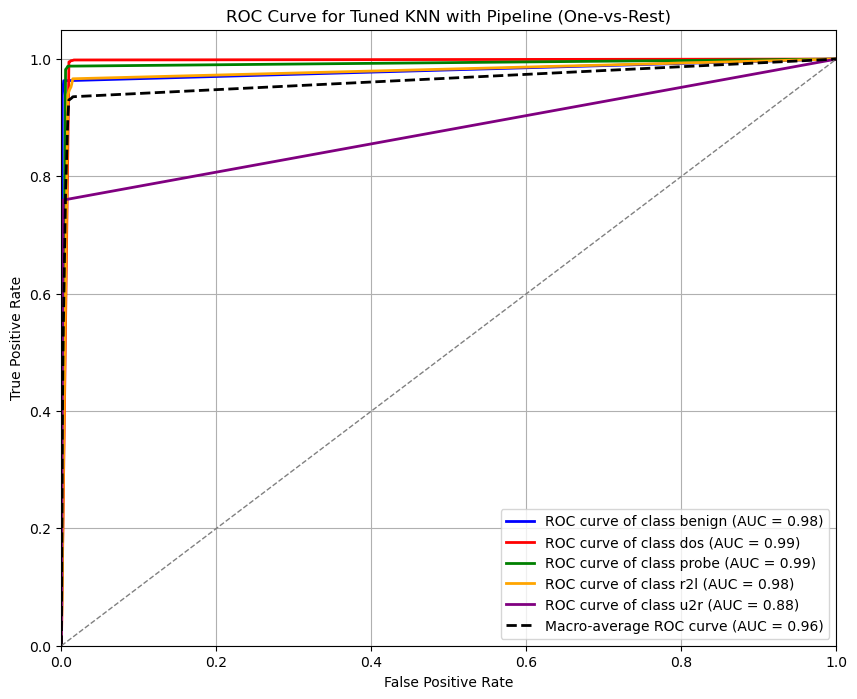

In [17]:
# ROC Curve Visualization
y_test_prob = pipeline.predict_proba(X_test)
y_test_bin = label_binarize(y_test, classes=np.unique(y))
n_classes = len(np.unique(y))

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Macro-average ROC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'orange', 'purple']
class_names = np.unique(y)
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {class_names[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot(fpr["macro"], tpr["macro"], color='black', lw=2, linestyle='--',
         label=f'Macro-average ROC curve (AUC = {roc_auc["macro"]:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Tuned KNN with Pipeline (One-vs-Rest)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()